In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [8]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [9]:
!labelme

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [12]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [13]:
images.as_numpy_iterator().next()

b'data\\images\\d50e5d87-0da6-11ee-96cc-dc21489725fc.jpg'

In [4]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [16]:
images.as_numpy_iterator().next()

array([[[167, 184, 178],
        [167, 184, 178],
        [162, 174, 170],
        ...,
        [ 39,  72,  87],
        [ 46,  86,  96],
        [ 43,  87,  96]],

       [[170, 187, 181],
        [170, 187, 181],
        [168, 183, 178],
        ...,
        [ 42,  74,  89],
        [ 40,  80,  92],
        [ 38,  80,  92]],

       [[174, 190, 187],
        [175, 191, 188],
        [173, 190, 184],
        ...,
        [ 49,  80, 100],
        [ 47,  82, 101],
        [ 48,  87, 102]],

       ...,

       [[109, 138, 134],
        [116, 145, 141],
        [ 99, 128, 126],
        ...,
        [ 24,  46,  60],
        [ 21,  47,  60],
        [ 21,  49,  61]],

       [[112, 142, 144],
        [115, 145, 147],
        [107, 136, 140],
        ...,
        [ 23,  42,  56],
        [ 22,  46,  58],
        [ 22,  49,  60]],

       [[111, 142, 145],
        [110, 141, 144],
        [113, 144, 149],
        ...,
        [ 23,  43,  54],
        [ 23,  45,  56],
        [ 25,  49,  59]]

In [17]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [19]:
plot_images = image_generator.next()

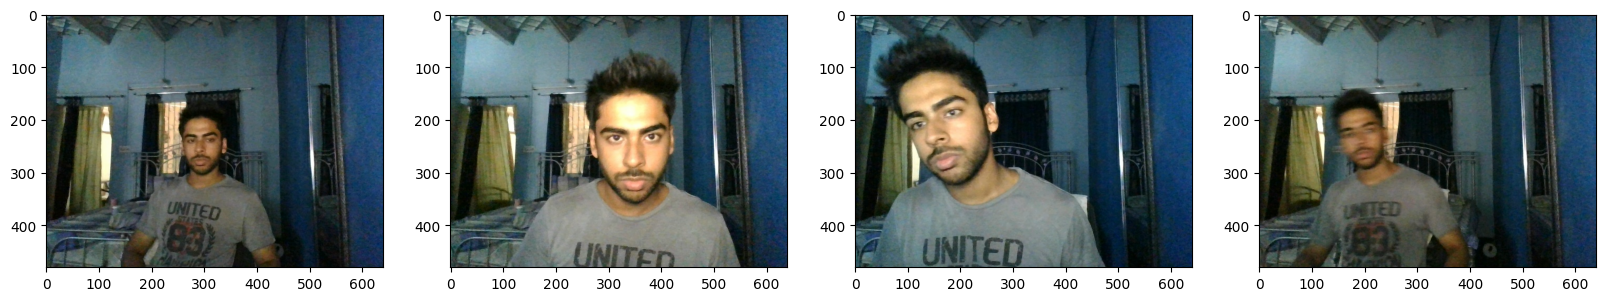

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# Partition Unaugmented Data

In [5]:
90*.7 # 63 to train

62.99999999999999

In [6]:
90*.15 # 14 and 13 to test and val

13.5

In [23]:
#Moving the Matching labels
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# Apply Image Augmentation on Images and Labels using Albumentations

In [7]:
import albumentations as alb

In [8]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [9]:
img = cv2.imread(os.path.join('data','train','images','a6cb95f6-0da6-11ee-b570-dc21489725fc.jpg'))

In [10]:
with open(os.path.join('data', 'train', 'labels', 'a6cb95f6-0da6-11ee-b570-dc21489725fc.json'), 'r') as f:
    label = json.load(f)

In [11]:
label['shapes'][0]['points']

[[222.4875621890547, 127.06467661691543],
 [383.18407960199005, 322.58706467661693]]

In [12]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [13]:
coords

[222.4875621890547, 127.06467661691543, 383.18407960199005, 322.58706467661693]

In [14]:
coords = list(np.divide(coords, [640,480,640,480]))

In [15]:
coords

[0.34763681592039797,
 0.26471807628524047,
 0.5987251243781094,
 0.6720563847429519]

In [16]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [17]:
augmented['bboxes'][0][2:]

(0.8900276395798784, 0.7843007186290769)

In [18]:
augmented['bboxes']

[(0.5329242675511332,
  0.34980652294085124,
  0.8900276395798784,
  0.7843007186290769)]

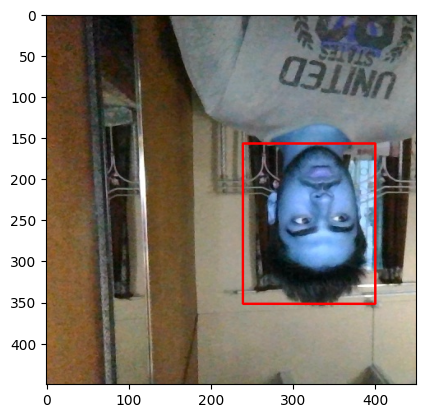

In [19]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# Build and Run Augmentation Pipeline

In [20]:
import cv2
import os
import json
import numpy as np

for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            points = label['shapes'][0]['points']
            x_min = min(points[0][0], points[1][0])
            x_max = max(points[0][0], points[1][0])
            y_min = min(points[0][1], points[1][1])
            y_max = max(points[0][1], points[1][1])

            # Check if x_max is greater than x_min
            if x_max > x_min:
                coords[0] = x_min
                coords[1] = y_min
                coords[2] = x_max
                coords[3] = y_max
                coords = list(np.divide(coords, [640, 480, 640, 480]))

            else:
                print(f'Invalid bounding box for image {image}')
                continue

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)


In [21]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [22]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [23]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [24]:
train_images.as_numpy_iterator().next()

array([[[0.18486519, 0.3074142 , 0.40398285],
        [0.18314952, 0.2923407 , 0.38578433],
        [0.19656862, 0.30520833, 0.37941176],
        ...,
        [0.34454656, 0.47444853, 0.5009191 ],
        [0.62126225, 0.73498774, 0.7372549 ],
        [0.6370711 , 0.72818625, 0.69191176]],

       [[0.17506127, 0.29761028, 0.39025736],
        [0.16960785, 0.27775735, 0.3915441 ],
        [0.16231617, 0.28045344, 0.37745097],
        ...,
        [0.40870097, 0.47843137, 0.49454656],
        [0.4       , 0.47144607, 0.48713234],
        [0.41476715, 0.4973652 , 0.4990809 ]],

       [[0.18468137, 0.3033088 , 0.42107844],
        [0.19889706, 0.30919117, 0.45281863],
        [0.17487745, 0.29252452, 0.4327206 ],
        ...,
        [0.32487744, 0.39987746, 0.41409314],
        [0.41145834, 0.5197304 , 0.5310049 ],
        [0.36403185, 0.50539213, 0.5112745 ]],

       ...,

       [[0.01348039, 0.04491422, 0.05159314],
        [0.23756127, 0.24105392, 0.22181372],
        [0.4297794 , 0

# Prepare Labels

In [25]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [26]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [27]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [28]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [29]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.2063, 0.2179, 0.5635, 0.6523], dtype=float16))

In [30]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

In [31]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [32]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [33]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [34]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0]], dtype=uint8),
 array([[0.01196, 0.03125, 0.5337 , 0.752  ],
        [0.     , 0.2546 , 0.4604 , 0.9756 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.09534, 0.4246 , 0.7563 ],
        [0.4307 , 0.2058 , 0.7017 , 0.618  ],
        [0.3955 , 0.2236 , 0.872  , 0.793  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

# View Images and Annotations

In [35]:
data_samples = train.as_numpy_iterator()

In [36]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


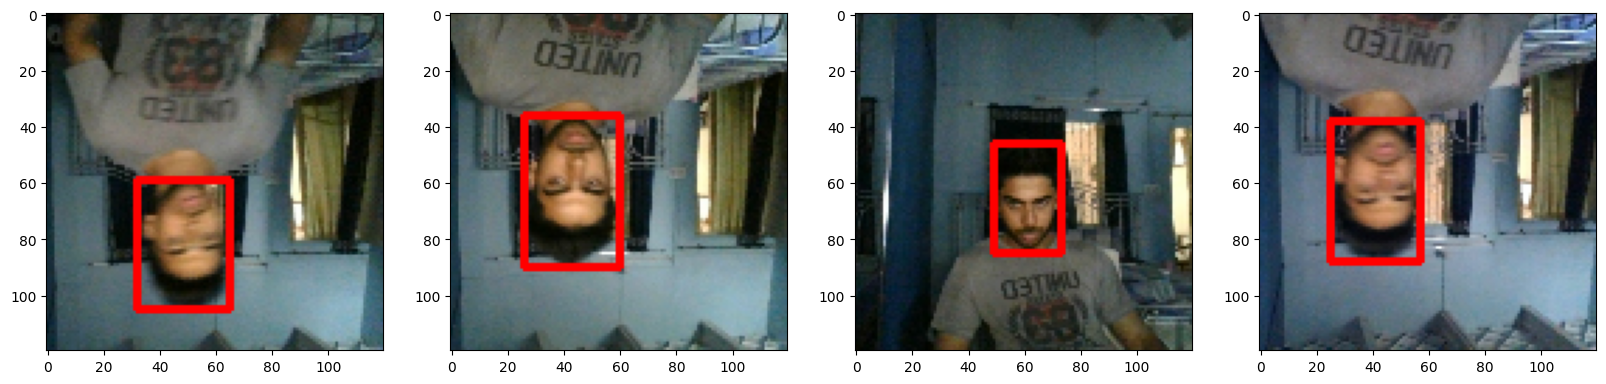

In [37]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# Build Deep Learning using the Functional API

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [39]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 38s 1us/step


In [40]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [41]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [42]:
facetracker = build_model()

In [43]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [44]:
X, y = train.as_numpy_iterator().next()

In [45]:
X.shape

(8, 120, 120, 3)

In [46]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 405ms/step


In [47]:
classes, coords

(array([[0.7100705 ],
        [0.76489216],
        [0.7528079 ],
        [0.72986   ],
        [0.6979821 ],
        [0.6939081 ],
        [0.6978788 ],
        [0.7057722 ]], dtype=float32),
 array([[0.4601697 , 0.59448427, 0.4373546 , 0.6768766 ],
        [0.40992522, 0.64760494, 0.43551818, 0.7538276 ],
        [0.47903338, 0.66102844, 0.46893075, 0.5573169 ],
        [0.38677037, 0.6389933 , 0.5384584 , 0.60543966],
        [0.424857  , 0.639487  , 0.45450646, 0.7001751 ],
        [0.38890418, 0.603669  , 0.45553425, 0.63400877],
        [0.43409708, 0.6058021 , 0.50289136, 0.6516654 ],
        [0.46042705, 0.6123234 , 0.45896888, 0.6110665 ]], dtype=float32))

In [48]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [49]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [50]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [51]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [52]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.67204>

In [53]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.45454004>

In [54]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.67204>

# Train Neural Network

In [55]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [56]:
model = FaceTracker(facetracker)

In [57]:
model.compile(opt, classloss, regressloss)

In [59]:
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
473/473 [==============================] - 523s 1s/step - total_loss: 0.2147 - class_loss: 0.0496 - regress_loss: 0.1898 - val_total_loss: 0.1459 - val_class_loss: 7.1947e-05 - val_regress_loss: 0.1458
Epoch 2/10
473/473 [==============================] - 523s 1s/step - total_loss: 0.0528 - class_loss: 0.0119 - regress_loss: 0.0469 - val_total_loss: 0.0779 - val_class_loss: 3.7642e-04 - val_regress_loss: 0.0777
Epoch 3/10
473/473 [==============================] - 545s 1s/step - total_loss: 0.0415 - class_loss: 0.0111 - regress_loss: 0.0359 - val_total_loss: 0.0195 - val_class_loss: 1.5065e-05 - val_regress_loss: 0.0195
Epoch 4/10
473/473 [==============================] - 550s 1s/step - total_loss: 0.0237 - class_loss: 0.0044 - regress_loss: 0.0215 - val_total_loss: 0.0291 - val_class_loss: 3.8253e-05 - val_regress_loss: 0.0291
Epoch 5/10
473/473 [==============================] - 551s 1s/step - total_loss: 0.0205 - class_loss: 0.0040 - regress_loss: 0.0186 - val_total_loss

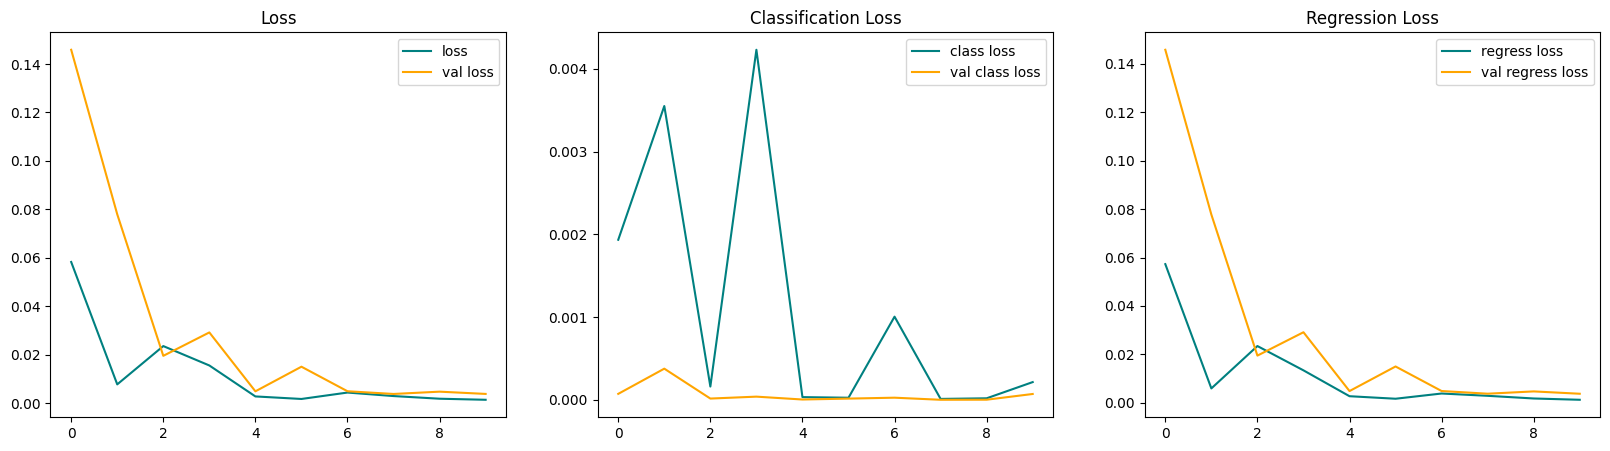

In [61]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [62]:
test_data = test.as_numpy_iterator()

In [63]:
test_sample = test_data.next()

In [64]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 272ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


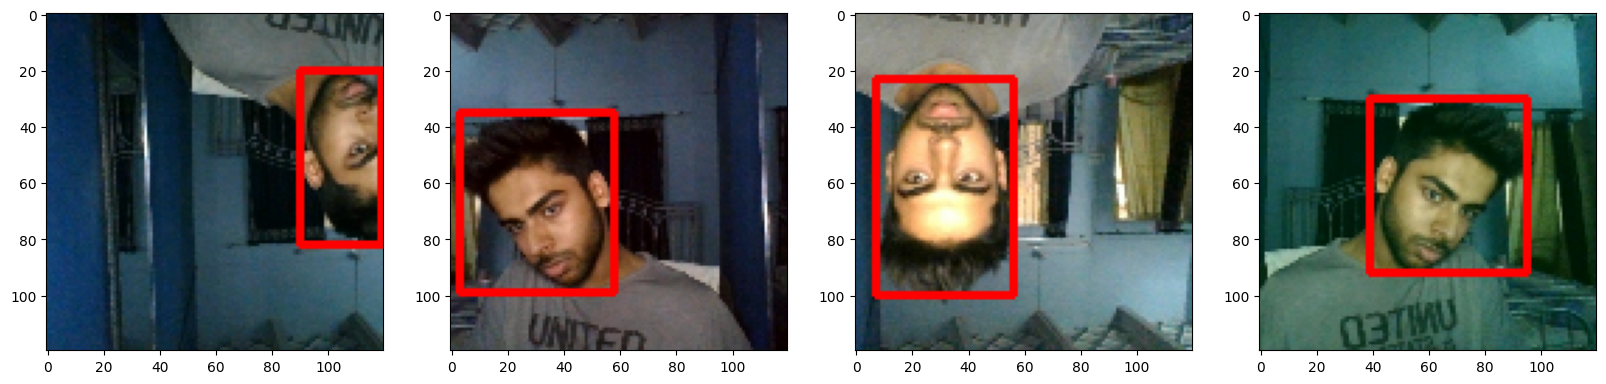

In [65]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [66]:
from tensorflow.keras.models import load_model

In [67]:
facetracker.save('facetracker.h5')

In [68]:
facetracker = load_model('facetracker.h5')

In [70]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 161ms/step
